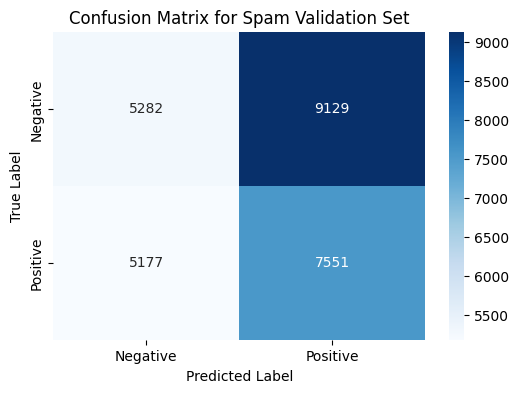


Spam Validation Set Accuracy: 0.4729
Spam Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.37      0.42     14411
           1       0.45      0.59      0.51     12728

    accuracy                           0.47     27139
   macro avg       0.48      0.48      0.47     27139
weighted avg       0.48      0.47      0.47     27139

108556    1
108557    0
108558    0
108559    1
108560    0
         ..
639995    1
639996    0
639997    1
639998    0
639999    0
Name: label, Length: 531444, dtype: int64


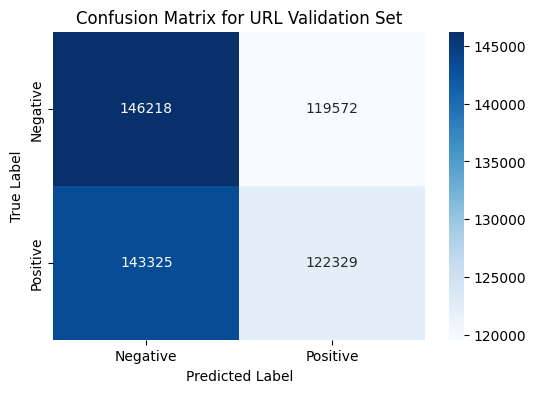


URL Validation Set Accuracy: 0.5053
URL Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.55      0.53    265790
           1       0.51      0.46      0.48    265654

    accuracy                           0.51    531444
   macro avg       0.51      0.51      0.50    531444
weighted avg       0.51      0.51      0.50    531444



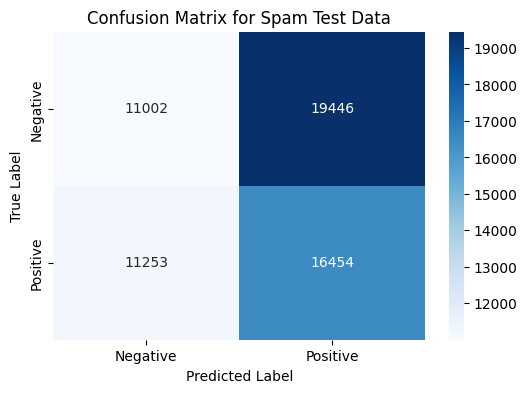


Spam Test Data Accuracy: 0.4721
Spam Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.36      0.42     30448
           1       0.46      0.59      0.52     27707

    accuracy                           0.47     58155
   macro avg       0.48      0.48      0.47     58155
weighted avg       0.48      0.47      0.47     58155



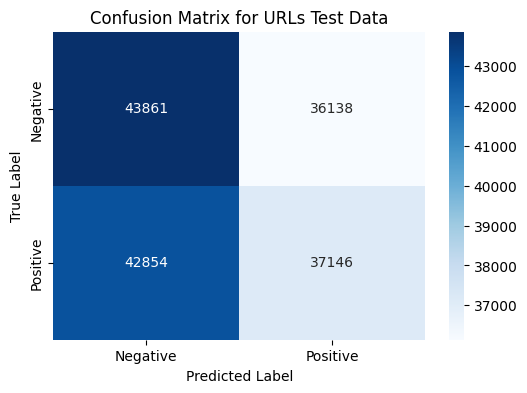


URLs Test Data Accuracy: 0.5063
URLs Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.55      0.53     79999
           1       0.51      0.46      0.48     80000

    accuracy                           0.51    159999
   macro avg       0.51      0.51      0.51    159999
weighted avg       0.51      0.51      0.51    159999



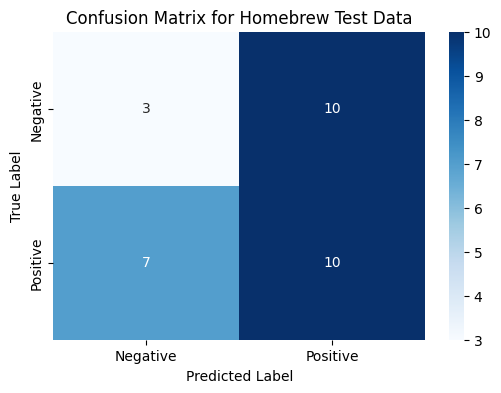


Homebrew Test Data Accuracy: 0.4333
Homebrew Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.23      0.26        13
           1       0.50      0.59      0.54        17

    accuracy                           0.43        30
   macro avg       0.40      0.41      0.40        30
weighted avg       0.41      0.43      0.42        30



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns

# Initialize the TfidfVectorizer for converting text data to features with a cap of 5000 features and English stop words removed.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
split_ratio = 0.8

# Load and preprocess the datasets, filling missing values and setting the label correctly
spam_test = pd.read_csv('./datasets/SpamHam/test.csv').fillna('')
spam_test['label'] = spam_test['label']


spam_ftrain = pd.read_csv('./datasets/SpamHam/train.csv').fillna('')
spam_ftrain['label'] = spam_ftrain['label']
spamsize = int(split_ratio*spam_ftrain.shape[0])
spam_train=spam_ftrain.iloc[:spamsize]
spam_valid=spam_ftrain.iloc[spamsize:]


urls_test = pd.read_csv('datasets/PhishingURLs/test.csv').fillna('')
urls_test['label'] = urls_test['label'].apply(lambda x: 1 if x == 1 else 0) # Convert labels to binary

urls_ftrain = pd.read_csv('datasets/PhishingURLs/train.csv').fillna('')
urls_ftrain['label'] = urls_ftrain['label'].apply(lambda x: 1 if x == 1 else 0) # Convert labels to binary
urlsize = int(split_ratio*spam_ftrain.shape[0])
urls_train=urls_ftrain.iloc[:urlsize]
urls_valid=urls_ftrain.iloc[urlsize:]


homebrew_data = pd.read_csv('HomebrewDataset.csv').fillna('')
homebrew_data['label'] = homebrew_data['label'].apply(lambda x: 1 if x==1 else 0) # Convert labels to binary






# Transform text data into TF-IDF feature vectors for each dataset
X_train_S = tfidf_vectorizer.fit_transform(spam_train['text'])
y_train_S = spam_train['label']
X_valid_S = tfidf_vectorizer.fit_transform(spam_valid['text'])
y_valid_S = spam_valid['label']

X_train_U = tfidf_vectorizer.fit_transform(urls_train['text'])
y_train_U = spam_train['label']
X_valid_U = tfidf_vectorizer.fit_transform(urls_valid['text'])
y_valid_U = spam_valid['label']

# Train Logistic Regression model with balanced class weights and a high iteration number to ensure convergence

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_S, y_train_S)
model.fit(X_train_U, y_train_U)

# Define the evaluation function to calculate and print model performance metrics

def evaluate_model(X, y, model, dataset_name):
    predictions = model.predict(X)
    conf_matrix = confusion_matrix(y, predictions)
    accuracy = accuracy_score(y, predictions)

    # Plotting the confusion matrix using seaborn for better visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\n{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:\n", classification_report(y, predictions))


# Evaluate the model on the Spam Validation Data and URLs Validation Data

X_spam_valid = tfidf_vectorizer.transform(spam_valid['text'])
Y_spam_valid = spam_valid['label']
evaluate_model(X_spam_valid, Y_spam_valid, model, "Spam Validation Set")

X_urls_valid = tfidf_vectorizer.transform(urls_valid['text'])
y_urls_valid = urls_valid['label']
print(y_urls_valid)
evaluate_model(X_urls_valid, y_urls_valid, model, "URL Validation Set")

# Evaluate the model on the Spam Test Data, URLs Test Data, and Homebrew Test Data

X_spam_test = tfidf_vectorizer.transform(spam_test['text'])
y_spam_test = spam_test['label']
evaluate_model(X_spam_test, y_spam_test, model, "Spam Test Data")

X_urls_test = tfidf_vectorizer.transform(urls_test['text'])
y_urls_test = urls_test['label']   
evaluate_model(X_urls_test, y_urls_test, model, "URLs Test Data")

X_homebrew_test = tfidf_vectorizer.transform(homebrew_data['text'])
y_homebrew_test = homebrew_data['label']
evaluate_model(X_homebrew_test, y_homebrew_test, model, "Homebrew Test Data")

